In [1]:
import uuid, sys, os
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import ast
import math
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from Bio.PDB import PDBParser, PPBuilder
from sklearn import metrics
from scipy import stats
from collections import Counter

from transformers import EsmModel, AutoTokenizer # huggingface
import esm

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
torch.manual_seed(0)
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from accelerate import Accelerator
import training_utils.partitioning_utils as pat_utils
from torch.utils.checkpoint import checkpoint

# Postional encodings
# from rotary_embedding_torch import RotaryEmbedding
# from some_utils.RoPE_for_ViT import RoPEAttention
# from some_utils.ALiBi2D import ALiBi2DTransformerLayer

# LoRA
from peft import LoraConfig, get_peft_model

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
print("PyTorch:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.1.0+cu118
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [3]:
requests.get("https://api.wandb.ai/status").status_code

import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/c9/0/203261/.netrc
wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 0):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing

seq_embed_dimension = 1280 #| 960 | 1152
struct_embed_dimension = 256
number_of_recycles = 2
padding_value = -5000

In [6]:
## Output path
# trained_model_dir = "/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116"

## Embeddings paths
binders_embeddings = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
targets_embeddings = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


## Loading data

### Loading PPint dataframe

In [7]:
path_to_mmseqs_clustering = "/work3/s232958/data/PPint_DB/3_å_dataset5_singlefasta/clusterRes40"
all_seqs, clust, clust_keys = pat_utils.mmseqs_parser(path_to_mmseqs_clustering)

path_to_interaction_df = "/work3/s232958/data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz"
disordered_interfaces_df = pd.read_csv(path_to_interaction_df,index_col=0).reset_index(drop=True)
disordered_interfaces_df["PDB_chain_name"] = (disordered_interfaces_df["PDB"] + "_" + disordered_interfaces_df["chainname"]).tolist()
disordered_interfaces_df["index_num"] = np.arange(len(disordered_interfaces_df))
disordered_interfaces_df["chain_name_index"] = [row["PDB_chain_name"] + "_" + str(row["index_num"]) for index, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df = disordered_interfaces_df.set_index("PDB_interface_name")
disordered_interfaces_df["interface_residues"] = disordered_interfaces_df["interface_residues"].apply(lambda x: ast.literal_eval(x))
# disordered_interfaces_df["inter_chain_hamming"] = [1 - (Ldistance(seq.split("-")[0], seq.split("-")[1]))/np.max([len(seq.split("-")[0]), len(seq.split("-")[1])]) for seq in disordered_interfaces_df["protien_interface_sequences"]]
disordered_interfaces_df["dimer"] = disordered_interfaces_df["inter_chain_hamming"] > 0.60
disordered_interfaces_df["clust_keys"] = [clust_keys.get(row["chain_name_index"]) for index, row in disordered_interfaces_df.iterrows()] 

pdb_interface_and_clust_keys = {index:disordered_interfaces_df.loc[index,"clust_keys"].values.tolist() for index in tqdm(disordered_interfaces_df.index.drop_duplicates(), total=len(disordered_interfaces_df)/2)}
new_clusters, new_clusters_clustkeys = pat_utils.recluster_mmseqs_keys_to_non_overlapping_groups(pdb_interface_and_clust_keys)

### Creating train and test datasets based on train and test-idexes
train_indexes, test_indexes = pat_utils.run_train_test_partition(interaction_df=disordered_interfaces_df,
                                                    clustering=new_clusters, # Clusters from Bidentate-graphs
                                                    train_ratio=0.8, 
                                                    test_ratio=0.2, 
                                                    v=True, 
                                                    seed=0)

disordered_interfaces_df["ID"] = [row["PDB"]+"_"+str(row["interface_index"])+"_"+row["chainname"] for __, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df["PDB_interface_name"] = disordered_interfaces_df.index

100%|██████████████████████████████████████████████████████████████████████████| 24725/24725.0 [00:31<00:00, 787.02it/s]
100%|█████████████████████████████████████████████████████████████████████████| 27834/27834 [00:00<00:00, 853181.65it/s]


0.8
0.2


In [8]:
grouped = {}
for _, row in disordered_interfaces_df.iterrows():
    iface = row["PDB_interface_name"]
    seq = row["sequence"]
    rid = row["ID"]
    dimer = row["dimer"]
    
    if iface not in grouped:
        grouped[iface] = {
            "sequences": [],
            "IDs": [],
            "dimer": dimer,        # keep the dimer value for this interface
        }
    else:
        # Optional: sanity-check it's consistent per interface
        if grouped[iface]["dimer"] != dimer:
            print(f"Warning: multiple dimers for interface {iface}:",
                  grouped[iface]['dimer'], "vs", dimer)

    grouped[iface]["sequences"].append(seq)
    grouped[iface]["IDs"].append(rid)

records = []
for iface, vals in grouped.items():
    seqs = vals["sequences"]
    ids = vals["IDs"]
    if len(seqs) >= 2 and len(ids) >= 2:
        records.append({
            "interface_id": iface,
            "seq1": seqs[0],
            "seq2": seqs[1],
            "ID1": ids[0],
            "ID2": ids[1],
            "dimer": vals["dimer"],   # <- add dimer to final record
        })

PPint_interactions_NEW = pd.DataFrame(records)
PPint_interactions_NEW["seq_target_len"] = [len(row.seq1) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["seq_binder_len"] = [len(row.seq2) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["target_binder_id"] = PPint_interactions_NEW["ID1"] + "_" + PPint_interactions_NEW["ID2"]

PPint_interactions_NEW.head()

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
0,6NZA_0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,TVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIHAL...,6NZA_0_A,6NZA_0_B,True,461,459,6NZA_0_A_6NZA_0_B
1,9JKA_1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1_B,9JKA_1_C,True,362,362,9JKA_1_B_9JKA_1_C
2,8DQ6_1,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1_B,8DQ6_1_C,True,109,97,8DQ6_1_B_8DQ6_1_C
3,2YMZ_0,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0_A,2YMZ_0_B,True,130,130,2YMZ_0_A_2YMZ_0_B
4,6IDB_0,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,6IDB_0_A,6IDB_0_B,False,317,172,6IDB_0_A_6IDB_0_B


In [9]:
# # sample random 10%
# train_indexes_sample = random.sample(train_indexes, int(len(train_indexes) * 0.1))
# test_indexes_sample = random.sample(test_indexes, int(len(test_indexes) * 0.1))

In [10]:
# Df_train = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(train_indexes_sample)]
# Df_test = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(test_indexes_sample)]
# Df_train

In [11]:
# Df_train.seq_target_len.min()

In [12]:
# Df_test

### ESM-IF1

#### ESM-IF1 example use

In [ ]:
# ### from https://colab.research.google.com/github/facebookresearch/esm/blob/main/examples/inverse_folding/notebook_multichain.ipynb#scrollTo=99d74757

# model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
# # use eval mode for deterministic output e.g. without random dropout
# model = model.eval()

# fpath = '/work3/s232958/data/RAEL.pdb' # .pdb format is also acceptable
# chain_ids = ['A']
# structure = esm.inverse_folding.util.load_structure(fpath, chain_ids)
# coords, native_seqs = esm.inverse_folding.multichain_util.extract_coords_from_complex(structure)

# print(f'Loaded chains: {list(coords.keys())}\n')

# for chain_id in chain_ids:
#     print(f'Chain {chain_id} native sequence:')
#     print(native_seqs[chain_id])
#     print('\n')

# try:
#     import py3Dmol

#     def view_pdb(fpath, chain_ids, colors=['red','blue','green']):
#         with open(fpath) as ifile:
#             system = "".join([x for x in ifile])

#         view = py3Dmol.view(width=600, height=400)
#         view.addModelsAsFrames(system)
#         for chain_id, color in zip(chain_ids, colors):
#             view.setStyle({'model': -1, 'chain': chain_id}, {"cartoon": {'color': color}})
#         view.zoomTo()
#         view.show()

# except ImportError:
#     def view_pdb(fpath, chain_id):
#         print("Install py3Dmol to visualize, or use pymol")
# view_pdb(fpath, ['A'])

# target_chain_id = 'A'
# sampled_seq = esm.inverse_folding.multichain_util.sample_sequence_in_complex(
#     model, coords, target_chain_id, temperature=1.)

# recovery = np.mean([(a==b) for a, b in zip(native_seqs[target_chain_id], sampled_seq)])
# print('Sequence recovery:', recovery)

# # Lower sampling temperature typically results in higher sequence recovery but less diversity

# target_chain_id = 'A'
# sampled_seq = esm.inverse_folding.multichain_util.sample_sequence_in_complex(
#     model, coords, target_chain_id, temperature=1e-6)

# recovery = np.mean([(a==b) for a, b in zip(native_seqs[target_chain_id], sampled_seq)])
# print('Sequence recovery:', recovery)

# target_chain_id = 'A'
# rep = esm.inverse_folding.multichain_util.get_encoder_output_for_complex(model, alphabet, coords, target_chain_id)
# len(coords[target_chain_id]), rep.shape

#### Random sampling PPint df

In [13]:
random.seed(0)   # any fixed number
rsample_forESM_IF = random.sample(train_indexes, 100)
rsample_forESM_IF_df = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(rsample_forESM_IF)]
rsample_forESM_IF_df

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
224,8TII_0,TRVFKKASPNGKLTVYLGKRDFVDHIDLVEPVDGVVLVDPEYLKER...,EVQLVESGGGLVQPGGSLRLSCAASGFNVSSSYIHWVRQAPGKGLE...,8TII_0_A,8TII_0_H,False,297,212,8TII_0_A_8TII_0_H
646,7XGM_0,IAEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDAT...,AEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDATV...,7XGM_0_A,7XGM_0_B,True,297,296,7XGM_0_A_7XGM_0_B
890,4BWV_0,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,4BWV_0_A,4BWV_0_B,True,227,227,4BWV_0_A_4BWV_0_B
1372,4LR3_1,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,4LR3_1_B,4LR3_1_C,True,164,164,4LR3_1_B_4LR3_1_C
1960,2ZLW_2,VLSAADKTNVKAAWSKVGGHAGEYGAEALERMFLGFPTTKTYFPHF...,VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFG...,2ZLW_2_C,2ZLW_2_D,False,141,146,2ZLW_2_C_2ZLW_2_D
...,...,...,...,...,...,...,...,...,...
23515,6S8S_0,KGVTQYYAYVTERQKVHCLNTLFSRLQINQSIIFCNSSQRVELLAK...,DLFGDDIEEIPDTDFDFEGNLALFDKAAVFEEIDTYE,6S8S_0_A,6S8S_0_B,False,168,37,6S8S_0_A_6S8S_0_B
23785,6J6T_1,ATSSTAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVF...,TAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVFPGRC...,6J6T_1_B,6J6T_1_C,True,356,344,6J6T_1_B_6J6T_1_C
23819,7VUZ_0,VFLILFIALVGLVGNGFVLWLLGFRMRRNAFSVYVLSLAGADFLFL...,TLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGKSTI...,7VUZ_0_R,7VUZ_0_A,False,251,218,7VUZ_0_R_7VUZ_0_A
24452,1S3Q_1,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,1S3Q_1_B,1S3Q_1_D,True,154,154,1S3Q_1_B_1S3Q_1_D


In [14]:
del train_indexes, test_indexes, disordered_interfaces_df, PPint_interactions_NEW

#### Downloading PDBs from the random sample df

In [ ]:
# # Downloading random sample of PPint pdbs for ESM-IF
# pdbIDs_forESMIF = set([i.split("_")[0] for i in rsample_forESM_IF])

# def download_pdb(pdb_id, out_dir="/work3/s232958/data/PDB_files/PPint/", file_format="pdb"):
#     pdb_id = pdb_id.lower()
#     os.makedirs(out_dir, exist_ok=True)

#     if file_format == "pdb":
#         url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
#     elif file_format == "cif":
#         url = f"https://files.rcsb.org/download/{pdb_id}.cif"
#     else:
#         raise ValueError("file_format must be 'pdb' or 'cif'")

#     response = requests.get(url)

#     if response.status_code == 200:
#         file_path = os.path.join(out_dir, f"{pdb_id}.{file_format}")
#         with open(file_path, "wb") as f:
#             f.write(response.content)
#         # print(f"Downloaded: {file_path}")
#     else:
#         print(f"Failed to download {pdb_id}")

# for pid in tqdm(pdbIDs_forESMIF, total=len(pdbIDs_forESMIF), desc="Downloading PDBs"):
#     download_pdb(pid, file_format="pdb")

In [ ]:
def count_chains(pdb_path):
    parser = PDBParser(QUIET=True)
    ppb = PPBuilder()  # peptite builder for extracting sequences
    structure = parser.get_structure("protein", pdb_path)
    
    chain_ids = []
    chain_seqs = []

    for model in structure:
        for chain in model:
            chain_ids.append(chain.id)
            peptides = ppb.build_peptides(chain)
            if len(peptides) > 0:
                seq = "".join([p.get_sequence().__str__() for p in peptides])
            else:
                seq = "" 
            chain_seqs.append(seq)

    return chain_ids, chain_seqs

pdb_file_path = "/work3/s232958/data/PDB_files/PPint/2whd.pdb"
chains, seqs = count_chains(pdb_file_path)
print(chains, seqs)

In [ ]:
PDBchain_PDBinterface = {}
for __, row in rsample_forESM_IF_df.iterrows():
    pdb_chain1 = row.ID1.split("_")[0] + "_" + row.ID1.split("_")[-1]
    pdb_chain2 = row.ID2.split("_")[0] + "_" + row.ID2.split("_")[-1]
    pdb_interface = row.interface_id
    PDBchain_PDBinterface[pdb_chain1] = pdb_interface
    PDBchain_PDBinterface[pdb_chain2] = pdb_interface

#### Running ESM-IF for the sandom sample

In [ ]:
def to_numpy(x):
    try:
        return x.detach().cpu().numpy()
    except AttributeError:
        return np.asarray(x)

model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()

PPint_pdbs = "/work3/s232958/data/PDB_files/PPint"
output_dir  = "/work3/s232958/data/PPint_DB/rsample_ESMIF"
os.makedirs(output_dir, exist_ok=True)

ppb = PPBuilder()
pdb_parser = PDBParser(QUIET=True)

def get_valid_protein_chains(pdb_file):
    structure = esm.inverse_folding.util.load_structure(pdb_file)
    chains = []

    for chain in structure:
        seq = str(chain.seq)
        if all(res.isalpha() for res in seq): 
            chains.append(chain.chain_id)
    return structure, chains

for pdb_name in tqdm(os.listdir(PPint_pdbs), total=len(os.listdir(PPint_pdbs)), desc = "Computing ESM-IF structural embeddings"):

    pdb_file_path = os.path.join(PPint_pdbs, pdb_name)
    PDBid = pdb_name[:-4].upper()

    try:
        structure = esm.inverse_folding.util.load_structure(pdb_file_path)
        coords, native_seqs = esm.inverse_folding.multichain_util.extract_coords_from_complex(structure)
    except Exception as e:
        print(f"⚠ Could not parse {pdb_name}: {e}")
        continue

    valid_chains = list(coords.keys())
    # print(f"{pdb_name} → ESM-IF chains: {valid_chains}")
    if len(valid_chains) == 0:
        print(f"No valid chains found, skipping {pdb_name}")
        continue
        
    df_slice = rsample_forESM_IF_df[rsample_forESM_IF_df.interface_id.str.startswith(PDBid)]
    if df_slice.empty:
        print(f"No interface entries for {PDBid}, skipping.")
        continue

    selected_chains = set()
    for _, row in df_slice.iterrows():
        c1 = row.ID1[-1]
        c2 = row.ID2[-1]

        if c1 in valid_chains:
            selected_chains.add(c1)
        if c2 in valid_chains:
            selected_chains.add(c2)

    if len(selected_chains) == 0:
        print(f"⚠ None of the interface chains match ESM-IF chains for {PDBid}")
        continue

    for chain in sorted(selected_chains):
        try:
            emb = esm.inverse_folding.multichain_util.get_encoder_output_for_complex(model, alphabet, coords, chain)
            emb_np = emb.detach().cpu().numpy()
            out_path = os.path.join(output_dir, f"{PDBid}_{chain}.npy")
            np.save(out_path, emb_np)
            # print(f"Saved: {out_path}")

        except Exception as e:
            print(f"❌ Failed embedding {PDBid} chain {chain}: {e}")

#### Some wrangling after ESM-IF computed

In [15]:
identifiers = set()
for npfile in os.listdir("/work3/s232958/data/PPint_DB/rsample_ESMIF"):
    id_ = npfile.split("_")[0]
    identifiers.add(id_)
len(identifiers)

identifiers2 = set()
for interface in rsample_forESM_IF:
    id_ = interface.split("_")[0]
    identifiers2.add(id_)
dif = identifiers2 - identifiers
dif

identifiers3 = set()
for pdbname in os.listdir("/work3/s232958/data/PDB_files/PPint"):
    id_ = pdbname.split(".")[0].upper()
    if id_ in dif:
        print(id_)
    identifiers3.add(id_)
len(identifiers3)

7XG6
3PJ0
3R1Z
7R4G
3MBX
7DVQ
5GM2
8TII


298

In [16]:
rsample_forESM_IF_df

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
224,8TII_0,TRVFKKASPNGKLTVYLGKRDFVDHIDLVEPVDGVVLVDPEYLKER...,EVQLVESGGGLVQPGGSLRLSCAASGFNVSSSYIHWVRQAPGKGLE...,8TII_0_A,8TII_0_H,False,297,212,8TII_0_A_8TII_0_H
646,7XGM_0,IAEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDAT...,AEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDATV...,7XGM_0_A,7XGM_0_B,True,297,296,7XGM_0_A_7XGM_0_B
890,4BWV_0,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,4BWV_0_A,4BWV_0_B,True,227,227,4BWV_0_A_4BWV_0_B
1372,4LR3_1,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,4LR3_1_B,4LR3_1_C,True,164,164,4LR3_1_B_4LR3_1_C
1960,2ZLW_2,VLSAADKTNVKAAWSKVGGHAGEYGAEALERMFLGFPTTKTYFPHF...,VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFG...,2ZLW_2_C,2ZLW_2_D,False,141,146,2ZLW_2_C_2ZLW_2_D
...,...,...,...,...,...,...,...,...,...
23515,6S8S_0,KGVTQYYAYVTERQKVHCLNTLFSRLQINQSIIFCNSSQRVELLAK...,DLFGDDIEEIPDTDFDFEGNLALFDKAAVFEEIDTYE,6S8S_0_A,6S8S_0_B,False,168,37,6S8S_0_A_6S8S_0_B
23785,6J6T_1,ATSSTAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVF...,TAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVFPGRC...,6J6T_1_B,6J6T_1_C,True,356,344,6J6T_1_B_6J6T_1_C
23819,7VUZ_0,VFLILFIALVGLVGNGFVLWLLGFRMRRNAFSVYVLSLAGADFLFL...,TLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGKSTI...,7VUZ_0_R,7VUZ_0_A,False,251,218,7VUZ_0_R_7VUZ_0_A
24452,1S3Q_1,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,1S3Q_1_B,1S3Q_1_D,True,154,154,1S3Q_1_B_1S3Q_1_D


In [17]:
PDBid_fromDf = set([int_id.split("_")[0] for int_id in list(rsample_forESM_IF_df.interface_id)])
PDBid_fromEmb = set([int_id_chain.split("_")[0] for int_id_chain in os.listdir("/work3/s232958/data/PPint_DB/rsample_ESMIF/")])
print(len(PDBid_fromEmb), len(PDBid_fromDf))

183 100


In [18]:
rsample_forESM_IF_df_filtered = rsample_forESM_IF_df[rsample_forESM_IF_df["interface_id"].str.split("_").str[0].isin(PDBid_fromEmb)]
rsample_forESM_IF_df_filtered

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
646,7XGM_0,IAEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDAT...,AEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDATV...,7XGM_0_A,7XGM_0_B,True,297,296,7XGM_0_A_7XGM_0_B
890,4BWV_0,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,4BWV_0_A,4BWV_0_B,True,227,227,4BWV_0_A_4BWV_0_B
1372,4LR3_1,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,4LR3_1_B,4LR3_1_C,True,164,164,4LR3_1_B_4LR3_1_C
1960,2ZLW_2,VLSAADKTNVKAAWSKVGGHAGEYGAEALERMFLGFPTTKTYFPHF...,VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFG...,2ZLW_2_C,2ZLW_2_D,False,141,146,2ZLW_2_C_2ZLW_2_D
2257,4E0B_0,NAKVAVIGAAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAAD...,AKVAVIGAAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAADL...,4E0B_0_A,4E0B_0_B,True,302,303,4E0B_0_A_4E0B_0_B
...,...,...,...,...,...,...,...,...,...
23515,6S8S_0,KGVTQYYAYVTERQKVHCLNTLFSRLQINQSIIFCNSSQRVELLAK...,DLFGDDIEEIPDTDFDFEGNLALFDKAAVFEEIDTYE,6S8S_0_A,6S8S_0_B,False,168,37,6S8S_0_A_6S8S_0_B
23785,6J6T_1,ATSSTAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVF...,TAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVFPGRC...,6J6T_1_B,6J6T_1_C,True,356,344,6J6T_1_B_6J6T_1_C
23819,7VUZ_0,VFLILFIALVGLVGNGFVLWLLGFRMRRNAFSVYVLSLAGADFLFL...,TLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGKSTI...,7VUZ_0_R,7VUZ_0_A,False,251,218,7VUZ_0_R_7VUZ_0_A
24452,1S3Q_1,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,1S3Q_1_B,1S3Q_1_D,True,154,154,1S3Q_1_B_1S3Q_1_D


In [19]:
# Create the target side
df_target = rsample_forESM_IF_df_filtered.rename(columns={
    "seq1": "seq",
    "ID1": "ID",
    "seq_target_len": "length"
}).assign(type="target")

df_target = df_target[["interface_id", "type", "seq", "ID", "length","dimer", "target_binder_id"]]

# Create the binder side
df_binder = rsample_forESM_IF_df_filtered.rename(columns={
    "seq2": "seq",
    "ID2": "ID",
    "seq_binder_len": "length"
}).assign(type="binder")

df_binder = df_binder[["interface_id", "type", "seq", "ID", "length","dimer", "target_binder_id"]]

# Combine into long format
rsample_forESM_IF_df_filtered_longDf = pd.concat([df_target, df_binder], ignore_index=True)
rsample_forESM_IF_df_filtered_longDf["interface_id2"] =  [str(str(row.interface_id)+"_"+str(row.type)) for __, row in rsample_forESM_IF_df_filtered_longDf.iterrows()]
rsample_forESM_IF_df_filtered_longDf = rsample_forESM_IF_df_filtered_longDf.drop(columns = ["interface_id"]).rename(columns = {"interface_id2" : "interface_id"})
rsample_forESM_IF_df_filtered_longDf["seq_len"] = [len(row.seq) for __, row in rsample_forESM_IF_df_filtered_longDf.iterrows()]
rsample_forESM_IF_df_filtered_longDf

,type,seq,ID,length,dimer,target_binder_id,interface_id,seq_len
0,target,IAEAWSPATDERLRAAGIDAEDARRVVVTALEEDLRYGADVTSDAT...,7XGM_0_A,297,True,7XGM_0_A_7XGM_0_B,7XGM_0_target,297
1,target,IDIKKCNEQARDARLQHLEAQALETLQKTVENFEKPAFPCALIAGD...,4BWV_0_A,227,True,4BWV_0_A_4BWV_0_B,4BWV_0_target,227
2,target,MEMTNAQRLILSNQYKMMTMLDPANAERYRRLQTIIERGYGLQMRE...,4LR3_1_B,164,True,4LR3_1_B_4LR3_1_C,4LR3_1_target,164
3,target,VLSAADKTNVKAAWSKVGGHAGEYGAEALERMFLGFPTTKTYFPHF...,2ZLW_2_C,141,False,2ZLW_2_C_2ZLW_2_D,2ZLW_2_target,141
4,target,NAKVAVIGAAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAAD...,4E0B_0_A,302,True,4E0B_0_A_4E0B_0_B,4E0B_0_target,302
...,...,...,...,...,...,...,...,...
179,binder,DLFGDDIEEIPDTDFDFEGNLALFDKAAVFEEIDTYE,6S8S_0_B,37,False,6S8S_0_A_6S8S_0_B,6S8S_0_binder,37
180,binder,TAVGFDERMLLHSEFEVKAQPHPERPDRLRAIAASLATAGVFPGRC...,6J6T_1_C,344,True,6J6T_1_B_6J6T_1_C,6J6T_1_binder,344
181,binder,TLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGKSTI...,7VUZ_0_A,218,False,7VUZ_0_R_7VUZ_0_A,7VUZ_0_binder,218
182,binder,SISEKVEALNRQINAEIYSAYLYLSASYFDSIGLKGFSNWRVQWQE...,1S3Q_1_D,154,True,1S3Q_1_B_1S3Q_1_D,1S3Q_1_binder,154


In [20]:
del rsample_forESM_IF_df_filtered, PDBid_fromEmb, PDBid_fromDf

### PPint dataloader

#### loading seq emebeddings and struct emebeddings

In [ ]:
# class CLIP_PPint_analysis_dataset(Dataset):
#     def __init__(
#         self,
#         dframe,
#         paths,
#         seq_embedding_dim=1280,
#         struct_embedding_dim=512,
#         embedding_pad_value=-5000.0,
#         fixed_max_blen=None,
#         fixed_max_tlen=None,
#     ):
#         super().__init__()
#         self.dframe = dframe.copy()
#         self.types = self.dframe["type"]
#         self.seq_embedding_dim = int(seq_embedding_dim)
#         self.struct_embedding_dim = int(struct_embedding_dim)
#         self.emb_pad = float(embedding_pad_value)

#         # lengths
#         self.max_len = self.dframe["seq_len"].max() if fixed_max_blen is None else fixed_max_blen

#         # paths
#         self.encoding_bpath, self.encoding_tpath, self.esmif_path = paths

#         # index & storage
#         self.dframe.set_index("interface_id", inplace=True)
#         self.accessions = self.dframe.index.astype(str).tolist()
#         self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
#         self.samples = []

#         for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
#             row = self.dframe.loc[accession]
#             parts = row.target_binder_id.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
#             type_ = row.type 

#             ### --- SEQUENCE embeddings (pad to fixed lengths) --- ###
#             if type_ == "target":
#                 seq_id = "_".join(parts[:3])
#                 seq_emb = np.load(os.path.join(self.encoding_tpath, f"{seq_id}.npy"))     # [Lt, D]
#                 if seq_emb.shape[1] != self.seq_embedding_dim:
#                     raise ValueError("Embedding dim mismatch with 'seq_embedding_dim'.")
#                 if seq_emb.shape[0] < self.max_len:
#                     seq_emb = np.concatenate([seq_emb, np.full((self.max_len - seq_emb.shape[0], seq_emb.shape[1]), self.emb_pad, dtype=seq_emb.dtype)], axis=0)
#                 else:
#                     seq_emb = seq_emb[: self.max_len] # no padding was used

#                 struct_id = parts[0] + "_" + parts[2]
#                 struct_emb = np.load(os.path.join(self.esmif_path, f"{struct_id}.npy"))     # [Lt, D]
#                 if struct_emb.shape[1] != self.struct_embedding_dim:
#                     raise ValueError("Embedding dim mismatch with 'struct_embedding_dim'.")
#                 if struct_emb.shape[0] < self.max_len:
#                     struct_emb = np.concatenate([struct_emb, np.full((self.max_len - struct_emb.shape[0], struct_emb.shape[1]), self.emb_pad, dtype=struct_emb.dtype)], axis=0)
#                 else:
#                     struct_emb = struct_emb[: self.max_len] # no padding was used

#             if type_ == "binder":
#                 seq_id = "_".join(parts[3:])
#                 seq_emb = np.load(os.path.join(self.encoding_bpath, f"{seq_id}.npy"))     # [Lb, D]
#                 if seq_emb.shape[1] != self.seq_embedding_dim:
#                     raise ValueError("Embedding dim mismatch with 'seq_embedding_dim'.")
#                 if seq_emb.shape[0] < self.max_len:
#                     seq_emb = np.concatenate([seq_emb, np.full((self.max_len - seq_emb.shape[0], seq_emb.shape[1]), self.emb_pad, dtype=seq_emb.dtype)], axis=0)
#                 else:
#                     seq_emb = seq_emb[: self.max_len] # no padding was used

#                 struct_id = parts[3] + "_" + parts[5]
#                 struct_emb  = np.load(os.path.join(self.esmif_path, f"{struct_id}.npy"))     # [Lb, D]
#                 if struct_emb.shape[1] != self.struct_embedding_dim:
#                     raise ValueError("Embedding dim mismatch with 'struct_embedding_dim'.")
#                 if struct_emb.shape[0] < self.max_len:
#                     struct_emb = np.concatenate([struct_emb, np.full((self.max_len - struct_emb.shape[0], struct_emb.shape[1]), self.emb_pad, dtype=struct_emb.dtype)], axis=0)
#                 else:
#                     struct_emb = struct_emb[: self.max_len] # no padding was used

#             self.samples.append((seq_emb, struct_emb))

#     # ---- Dataset API ----
#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         seq_arr, struct_arr = self.samples[idx]
#         seq_emb, struct_emb = torch.from_numpy(seq_arr).float(), torch.from_numpy(struct_arr).float()
#         label = torch.tensor(1, dtype=torch.float32)  # single scalar label
#         return seq_emb, struct_emb, label

#     def _get_by_name(self, name):
#         # Single item -> return exactly what __getitem__ returns
#         if isinstance(name, str):
#             return self.__getitem__(self.name_to_row[name])
        
#         # Multiple items -> fetch all
#         out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
#         seq_emb_list, struct_emb_list, lbl_list = zip(*out)
    
#         # Stack embeddings
#         seq_emb  = torch.stack([torch.as_tensor(x) for x in seq_emb_list],  dim=0)  # [B, ...]
#         struct_emb  = torch.stack([torch.as_tensor(x) for x in struct_emb_list],  dim=0)  # [B, ...]

#         # Stack labels
#         labels = torch.stack(lbl_list)  # [B]
    
#         return seq_emb, struct_emb, labels

# bemb_path = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
# temb_path = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"
# ESMIF_path = "/work3/s232958/data/PPint_DB/rsample_ESMIF"

# training_Dataset = CLIP_PPint_analysis_dataset(
#     rsample_forESM_IF_df_filtered_longDf,
#     paths=[bemb_path, temb_path, ESMIF_path],
#     seq_embedding_dim=1280,
#     struct_embedding_dim=512
# )

#### loading raw seqs and struct emebeddings

In [21]:
class CLIP_PPint_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        struct_embedding_dim=512,
        embedding_pad_value=-5000.0,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.types = self.dframe["type"]
        self.struct_embedding_dim = int(struct_embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_len = self.dframe["seq_len"].max() if fixed_max_blen is None else fixed_max_blen

        # paths
        self.encoding_bpath, self.encoding_tpath, self.esmif_path = paths

        # index & storage
        self.dframe.set_index("interface_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            row = self.dframe.loc[accession]
            parts = row.target_binder_id.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            type_ = row.type 

            ### --- SEQUENCE embeddings (pad to fixed lengths) --- ###
            if type_ == "target":
                seq = row.seq
                struct_id = parts[0] + "_" + parts[2]
                struct_emb = np.load(os.path.join(self.esmif_path, f"{struct_id}.npy"))     # [Lt, D]
                if struct_emb.shape[1] != self.struct_embedding_dim:
                    raise ValueError("Embedding dim mismatch with 'struct_embedding_dim'.")
                if struct_emb.shape[0] < self.max_len:
                    struct_emb = np.concatenate([struct_emb, np.full((self.max_len - struct_emb.shape[0], struct_emb.shape[1]), self.emb_pad, dtype=struct_emb.dtype)], axis=0)
                else:
                    struct_emb = struct_emb[: self.max_len] # no padding was used

            if type_ == "binder":
                seq = row.seq
                struct_id = parts[3] + "_" + parts[5]
                struct_emb  = np.load(os.path.join(self.esmif_path, f"{struct_id}.npy"))     # [Lb, D]
                if struct_emb.shape[1] != self.struct_embedding_dim:
                    raise ValueError("Embedding dim mismatch with 'struct_embedding_dim'.")
                if struct_emb.shape[0] < self.max_len:
                    struct_emb = np.concatenate([struct_emb, np.full((self.max_len - struct_emb.shape[0], struct_emb.shape[1]), self.emb_pad, dtype=struct_emb.dtype)], axis=0)
                else:
                    struct_emb = struct_emb[: self.max_len] # no padding was used

            self.samples.append((seq, struct_emb))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seqs, struct_arr = self.samples[idx]
        struct_emb = torch.from_numpy(struct_arr).float()
        label = torch.tensor(1.0)  # constant positive label
        return seqs, struct_emb, label

    def _get_by_name(self, names):
        if isinstance(names, str):   # single
            return self.__getitem__(self.name_to_row[names])

        # batch
        out = [self.__getitem__(self.name_to_row[n]) for n in names]
        seqs, struct_emb, labels = zip(*out)
        struct_emb = torch.stack(struct_emb)
        labels = torch.stack(labels)

        return list(seqs), struct_emb, labels

bemb_path = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
temb_path = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"
ESMIF_path = "/work3/s232958/data/PPint_DB/rsample_ESMIF"

training_Dataset = CLIP_PPint_analysis_dataset(
    rsample_forESM_IF_df_filtered_longDf,
    paths=[bemb_path, temb_path, ESMIF_path],
    struct_embedding_dim=512)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 184/184 [00:00<00:00, 390.39it/s]


## Contrastive Sequence-Structure Pre-training (CSSP)

In [22]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

#### ESM2 encoder

In [110]:
class ESM2EncoderOriginal(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [112]:
sequences = []
for i, row in rsample_forESM_IF_df_filtered_longDf.iterrows():
    seq_name = f"prot_{i}"
    sequence = str(row.seq)
    entry = (seq_name, sequence)
    sequences.append(entry)
sequences[:5]

# Embedings original seqeunces
encoder = ESM2EncoderOriginal().to("cuda")   # create model
embeds = encoder(seq)

print(embeds.shape)

# Mean pooling
seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0).to(device)
seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
seq_embed_pooled_START

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 31.73 GiB of which 4.75 MiB is free. Process 824595 has 1.38 GiB memory in use. Process 1113152 has 2.75 GiB memory in use. Process 1278767 has 6.83 GiB memory in use. Including non-PyTorch memory, this process has 20.76 GiB memory in use. Of the allocated memory 20.30 GiB is allocated by PyTorch, and 89.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
embeds

### ESM encoder with LoRA added

In [ ]:
# language_model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

# lora_cfg = LoraConfig(
#     task_type="FEATURE_EXTRACTION",
#     inference_mode=False,
#     r=4,
#     lora_alpha=1,
#     lora_dropout=0.1,
#     bias="none",
#     target_modules=["query", "value"],
#     layers_to_transform=list(range(25, 33)),  # last 8 layers
# )
# model = get_peft_model(language_model, lora_cfg)
# model

In [ ]:
# lora_cfg = LoraConfig(
#     task_type="FEATURE_EXTRACTION",
#     inference_mode=False,
#     r=16,
#     lora_alpha=128,
#     lora_dropout=0.1,
#     bias="none",
#     target_modules=["query", "key", "value", "dense"],
#     layers_to_transform=list(range(25, 33)),  # all layers
# )

In [69]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=16,
            lora_alpha=128,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [57]:
# encoder = ESM2EncoderLoRA()
# encoder = encoder.eval()
# sequences = ["MKTAGALA","GAY"]
# padded, mask = encoder(sequences)
# print(padded.shape)
# seq_mask_emb = create_key_padding_mask(embeddings = padded, padding_value = -5000.0).to(device)
# seq_embed_pooled_START = create_mean_of_non_masked(padded, seq_mask_emb)
# print(seq_embed_pooled_START)
# print(padded)

In [58]:
# # Embedings original seqeunces
# sequences = [
#     ("seq1", "MKTAGALA"),
#     ("seq2", "GAY")
# ]
# encoder = ESM2EncoderOriginal()   # create model
# encoder = encoder.eval()
# embeds = encoder(sequences)

# # Mean pooling
# seq_mask_emb = create_key_padding_mask(embeddings = embeds, padding_value = -5000.0)
# seq_embed_pooled_START = create_mean_of_non_masked(embeds, seq_mask_emb)
# seq_embed_pooled_START
# print(embeds)

### CSSPBoostingESM model architecture (lighter to avoid OutOfMemory error)

In [62]:
class CSSPBoostingESM(nn.Module):
    def __init__(
        self,
        seq_embed_dim=1280,
        struct_embed_dim=512,
        padding_value=-5000,
        num_heads=8,
        num_recycles=2
    ):
        super().__init__()

        self.seq_embed_dim = seq_embed_dim
        self.struct_embed_dim = struct_embed_dim
        self.padding_value = padding_value
        self.num_recycles = num_recycles

        # ESM2 encoder
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)

        # Self-attention
        self.seq_self_attn = nn.TransformerEncoderLayer(
            d_model=struct_embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )
        self.struct_self_attn = nn.TransformerEncoderLayer(
            d_model=struct_embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )

        # Cross attention
        self.seq_to_struct = nn.MultiheadAttention(
            embed_dim=struct_embed_dim, 
            num_heads=num_heads, 
            batch_first=True
        )
        self.struct_to_seq = nn.MultiheadAttention(
            embed_dim=struct_embed_dim, 
            num_heads=num_heads, 
            batch_first=True
        )

        # LayerNorm
        self.norm_seq = nn.LayerNorm(struct_embed_dim)
        self.norm_struct = nn.LayerNorm(struct_embed_dim)

        # Projection to CLIP space
        self.seq_projection = nn.Sequential(
            nn.Linear(struct_embed_dim, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        self.struct_projection = nn.Sequential(
            nn.Linear(struct_embed_dim, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward_transformer(self, layer, embeddings, mask):
        return checkpoint(
            lambda _emb: layer(_emb, src_key_padding_mask=mask),
            embeddings
        )

    def forward(self, sequences, struct_embed):
        # sequence embeddings
        seq_embed = self.seq_encoder(sequences)
        seq_embed = self.seq_down(seq_embed)

        # masks
        seq_mask = create_key_padding_mask(seq_embed, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)

        for _ in range(self.num_recycles):

            seq_trans = self.forward_transformer(
                self.seq_self_attn, 
                self.norm_seq(seq_embed), 
                seq_mask
            )

            struct_trans = self.forward_transformer(
                self.struct_self_attn, 
                self.norm_struct(struct_embed), 
                struct_mask
            )

            # cross attention
            seq_cross, _ = self.seq_to_struct(
                query=self.norm_seq(seq_trans),
                key=self.norm_seq(struct_trans),
                value=self.norm_seq(struct_trans),
                key_padding_mask=struct_mask,
            )

            struct_cross, _ = self.struct_to_seq(
                query=self.norm_struct(struct_trans),
                key=self.norm_struct(seq_trans),
                value=self.norm_struct(seq_trans),
                key_padding_mask=seq_mask,
            )

            seq_embed = seq_embed + seq_cross
            struct_embed = struct_embed + struct_cross

        # pool
        seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)

        # CLIP projection
        seq_full = F.normalize(self.seq_projection(seq_pooled), dim=-1)
        struct_full = F.normalize(self.struct_projection(struct_pooled), dim=-1)

        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits = scale * (seq_full * struct_full).sum(-1)

        return logits

    # -----------------------------
    # Training and validation steps
    # -----------------------------

    def training_step(self, batch, device):
        sequences, struct_embed, labels = batch
        labels = labels.float().to(device)
        logits = self.forward(sequences, struct_embed.to(device))
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        return loss

    def validation_step_PPint(self, batch, device):

        sequences, struct_embed, labels = batch
        struct_embed = struct_embed.to(device)
        
        with torch.no_grad():

            B = len(sequences)
    
            positive_logits = self.forward(sequences, struct_embed)

            rows, cols = torch.triu_indices(B, B, offset=1)
            negative_logits = self.forward(
                sequences[rows, :, :],
                struct_embed[cols, :, :]
            )
            
            loss = (
                F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits)) +
                F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits))
            ) / 2
            
            logit_matrix = torch.zeros((B, B), device=device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            diag_indices = torch.arange(B, device=device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(B).to(device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = peptide_ranks.float().pow(-1).mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            return loss, peptide_accuracy

    def validation_step_MetaDataset(self, batch, device):
        sequences, struct_embed, labels = batch
        struct_embed, labels = (
            struct_embed.to(device),
            labels.float().to(device),
        )
    
        with torch.no_grad():
            logits = self.forward(sequences, struct_embed).float()
            loss = F.binary_cross_entropy_with_logits(
                logits.view(-1), 
                labels.view(-1)
            )
            return logits, loss

    def calculate_logit_matrix(self, sequences, struct_embed):
        
        B = len(sequences)
        rows, cols = torch.triu_indices(B, B, offset=1)
        
        positive_logits = self.forward(sequences, struct_embed)
        negative_logits = self.forward(sequences[rows,:,:], struct_embed[cols,:,:])
        
        logit_matrix = torch.zeros((B, B), device=sequences.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(B, device=sequences.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

### CSSPBoostingESM model architecture (heavy)

In [60]:
class CSSPBoostingESM(nn.Module):
    def __init__(
        self,
        seq_embed_dim=1280,
        struct_embed_dim=512,
        padding_value=-5000,
        num_heads=8,
        num_recycles=2
    ):
        super().__init__()

        self.seq_embed_dim = seq_embed_dim
        self.struct_embed_dim = struct_embed_dim
        self.padding_value = padding_value
        self.num_recycles = num_recycles

        # ESM2 encoder
        self.seq_encoder = ESM2EncoderLoRA().to(device)

        # Self-attention
        self.seq_self_attn = nn.TransformerEncoderLayer(d_model=seq_embed_dim, nhead=num_heads, batch_first=True)
        self.struct_self_attn = nn.TransformerEncoderLayer(d_model=struct_embed_dim, nhead=num_heads, batch_first=True)

        # Project structure → seq dimension for cross-attention
        self.struct_to_seq_proj = nn.Linear(struct_embed_dim, seq_embed_dim)
        self.seq_to_struct_proj = nn.Linear(seq_embed_dim, struct_embed_dim)

        # Cross attention
        self.seq_to_struct = nn.MultiheadAttention(embed_dim=seq_embed_dim, num_heads=num_heads, batch_first=True, enable_flash_attention=True)
        self.struct_to_seq = nn.MultiheadAttention(embed_dim=struct_embed_dim, num_heads=num_heads, batch_first=True, enable_flash_attention=True)

        self.norm_seq = nn.LayerNorm(seq_embed_dim)
        self.norm_struct = nn.LayerNorm(struct_embed_dim)

        # Projection to CLIP space
        self.seq_projection = nn.Sequential(
            nn.Linear(seq_embed_dim, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        self.struct_projection = nn.Sequential(
            nn.Linear(struct_embed_dim, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed):
        # sequence embeddings
        seq_embed = self.seq_encoder(sequences)
        seq_embed = seq_embed.to(device)
        struct_embed = struct_embed.to(device)

        # masks
        seq_mask = create_key_padding_mask(seq_embed, self.padding_value)
        struct_mask = create_key_padding_mask(struct_embed, self.padding_value)

        for _ in range(self.num_recycles):

            seq_trans = self.seq_self_attn(self.norm_seq(seq_embed), src_key_padding_mask=seq_mask)
            struct_trans = self.struct_self_attn(self.norm_struct(struct_embed), src_key_padding_mask=struct_mask)

            # project dimensions for cross attention
            struct_as_seq = self.struct_to_seq_proj(struct_trans)
            seq_as_struct = self.seq_to_struct_proj(seq_trans)

            # print(f"seq_trans {seq_trans.shape}")
            # print(f"seq_as_struct {seq_as_struct.shape}")
            # print(f"struct_as_seq {struct_as_seq.shape}")
            # print(f"seq_mask {seq_mask.shape}")
            # print(f"struct_mask {struct_mask.shape}")
            
            # cross attention
            seq_cross, _ = self.seq_to_struct(
                query=self.norm_seq(seq_trans),
                key=self.norm_seq(struct_as_seq),
                value=self.norm_seq(struct_as_seq),
                key_padding_mask=struct_mask,
            )

            struct_cross, _ = self.struct_to_seq(
                query=self.norm_struct(struct_trans),
                key=self.norm_struct(seq_as_struct),
                value=self.norm_struct(seq_as_struct),
                key_padding_mask=seq_mask,
            )

            seq_embed = seq_embed + seq_cross
            struct_embed = struct_embed + struct_cross

        # pool
        seq_pooled = create_mean_of_non_masked(seq_embed, seq_mask)
        struct_pooled = create_mean_of_non_masked(struct_embed, struct_mask)

        # CLIP projection
        seq_full = F.normalize(self.seq_projection(seq_pooled), dim=-1)
        struct_full = F.normalize(self.struct_projection(struct_pooled), dim=-1)

        scale = torch.exp(self.logit_scale).clamp(max=100)
        logits = scale * (seq_full * struct_full).sum(-1)

        return logits

    def training_step(self, batch, device):
        sequences, struct_embed, labels = batch
        labels = labels.float().to(device)

        logits = self.forward(sequences, struct_embed)
        loss = F.binary_cross_entropy_with_logits(logits, labels)

        return loss

    def validation_step_PPint(self, batch, device):

        sequences, ESM_IF_embeddings, labels = batch
        sequences, ESM_IF_embeddings = sequences.to(device), ESM_IF_embeddings.to(device)
        
        with torch.no_grad():

            B = len(sequences)
    
            positive_logits, positive_loss = self.forward(sequences, ESM_IF_embeddings)
    
            rows, cols = torch.triu_indices(B, B, offset=1)
            negative_logits, negative_loss = self.forward(sequences[rows,:,:], ESM_IF_embeddings[cols,:,:])
            
            loss = (positive_loss + negative_loss) / 2
            
            torch.cuda.empty_cache()
            
            logit_matrix = torch.zeros((B, B),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            diag_indices = torch.arange(B, device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(B).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        sequences, ESM_IF_embeddings, labels = batch
        sequences, ESM_IF_embeddings = sequences.to(device), ESM_IF_embeddings.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits, loss = self.forward(sequences, ESM_IF_embeddings).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            
            return logits, loss

    def calculate_logit_matrix(self, sequences, ESM_IF_embeddings):
        
        B = len(sequences)
        rows, cols = torch.triu_indices(B, B, offset=1)
        
        positive_logits, positive_loss = self.forward(sequences, ESM_IF_embeddings)
        negative_logits, negative_loss = self.forward(sequences[rows,:,:], ESM_IF_embeddings[cols,:,:])
        
        logit_matrix = torch.zeros((B, B),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(B, device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [61]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    num_recycles=2
).to("cuda")

model

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: MultiheadAttention.__init__() got an unexpected keyword argument 'enable_flash_attention'

### Trianing loop simplified

In [63]:
# torch.cuda.empty_cache()

# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

# # Try to load ONLY the encoder
# enc = ESM2EncoderLoRA().to("cuda")
# print("Encoder loaded")

# # Try full model without seq_encoder
# model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512, num_recycles=2)
# model.seq_encoder = None
# model.to("cuda")
# print("Model loaded")

In [64]:
def collate_varlen(batch):
    struct_emb = torch.stack([x[1] for x in batch], dim=0)  # fixed length -> stack
    sequences = [x[0] for x in batch]                     # var-len -> list
    # lbls = torch.tensor([float(x[4]) for x in batch])
    lbls = torch.tensor([x[2].float() for x in batch])
    return sequences, struct_emb, lbls

train_dataloader = DataLoader(training_Dataset, batch_size=3, collate_fn=collate_varlen)

In [65]:
runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 5
batch_size = 3
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512, num_recycles=2 ).to("cuda")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = torch.Generator().manual_seed(SEED)

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
def batch(iterable, n=1):
    """Takes any indexable iterable (e.g., a list of observation IDs) and yields contiguous slices of length n."""
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device
    ):
        self.model = model
        self.training_loader = train_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()   # Make LoRA trainable!

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

            del loss, batch
            torch.cuda.empty_cache()

        return running_loss / len(self.training_loader)

    @torch.no_grad()
    def compute_start_embeddings(self):

        self.model.eval()
        self.model.seq_encoder.eval()   # IMPORTANT: freeze encoder for extraction

        all_embeds = []

        for sequences, __, __ in tqdm(self.training_loader, desc="Computing START embeddings"):

            # Extract embeddings DIRECTLY from encoder (LoRA included)
            seq_embed_batch = self.model.seq_encoder(sequences)

            # Move to CPU
            seq_embed_batch = seq_embed_batch.cpu()

            seq_mask = create_key_padding_mask(seq_embed_batch, padding_value=-5000.0)
            pooled = create_mean_of_non_masked(seq_embed_batch, seq_mask)

            all_embeds.append(pooled.cpu())

        return torch.cat(all_embeds, dim=0)

    @torch.no_grad()
    def compute_end_embeddings(self):
        return self.compute_start_embeddings()

    def train_model(self):

        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)

        print("\nExtracting START sequence embeddings...")
        start_embeddings = self.compute_start_embeddings()

        for epoch in range(1, self.EPOCHS + 1):
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")
            end_embeddings = self.compute_end_embeddings()
            drift = (end_embeddings - start_embeddings).norm(dim=1)
            plt.hist(drift.numpy(), bins=30)
            plt.title("Embedding drift per sequence")
            plt.show()
            
        print("\nExtracting END sequence embeddings...")
        end_embeddings = self.compute_end_embeddings()

        return start_embeddings, end_embeddings


Trainable parameters inside seq_encoder (LoRA layers):
   model.base_model.model.encoder.layer.25.attention.self.query.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.query.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.output.dense.lora_A.default.weight
   model.b

Running through epoch:   0%|                                                                     | 0/62 [00:00<?, ?it/s]/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Running through epoch: 100%|████████████████████████████████████████████████████████████| 62/62 [00:50<00:00,  1.23it/s]


Epoch 1: loss=0.0108


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


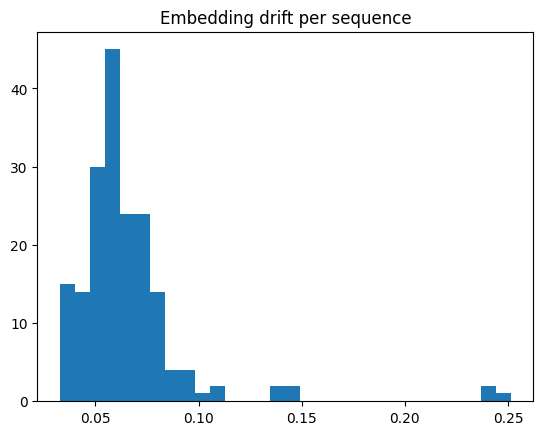

Running through epoch: 100%|████████████████████████████████████████████████████████████| 62/62 [00:50<00:00,  1.23it/s]


Epoch 2: loss=0.0001


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.04it/s]


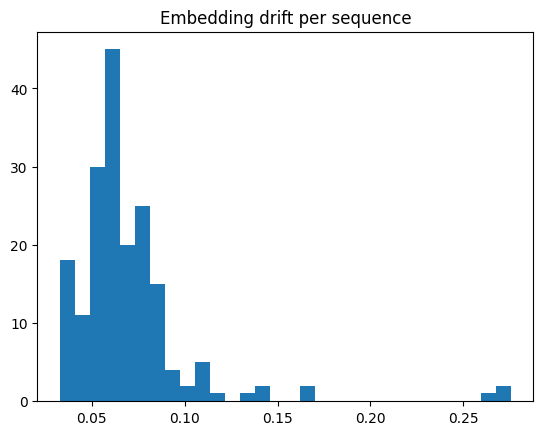

Running through epoch: 100%|████████████████████████████████████████████████████████████| 62/62 [00:50<00:00,  1.23it/s]


Epoch 3: loss=0.0001


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


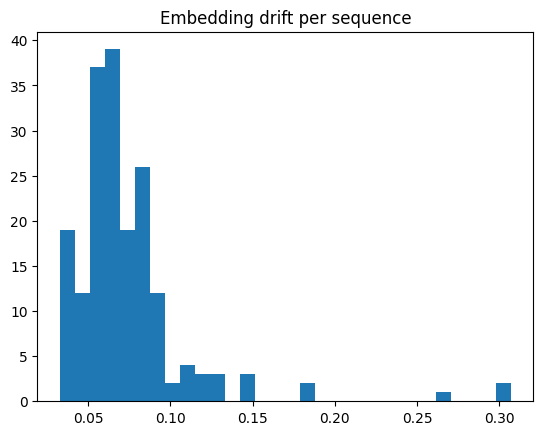

Running through epoch: 100%|████████████████████████████████████████████████████████████| 62/62 [00:50<00:00,  1.22it/s]


Epoch 4: loss=0.0000


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.01it/s]


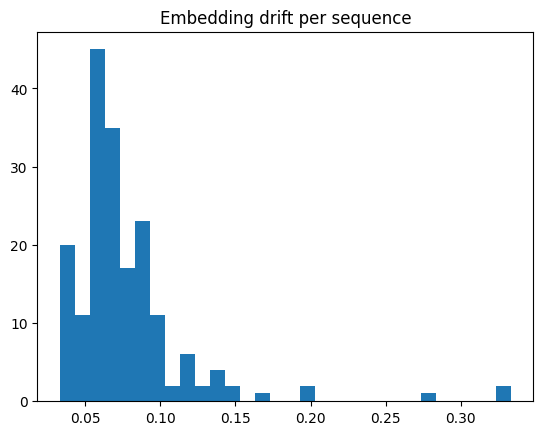

Running through epoch: 100%|████████████████████████████████████████████████████████████| 62/62 [00:50<00:00,  1.22it/s]


Epoch 5: loss=0.0000


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


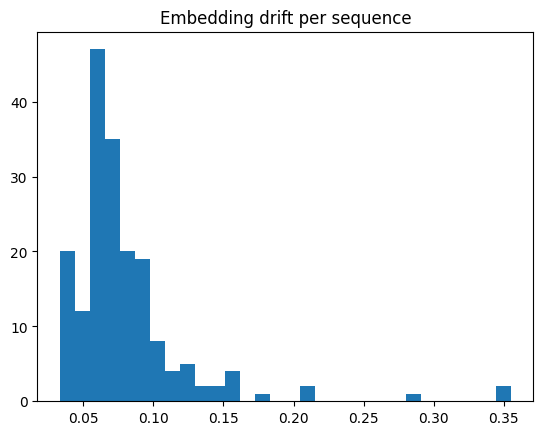


Extracting END sequence embeddings...


Computing START embeddings: 100%|███████████████████████████████████████████████████████| 62/62 [00:30<00:00,  2.02it/s]


In [67]:
# accelerator
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            optimizer=optimizer,
            epochs=EPOCHS,
            device=device,
)
torch.cuda.empty_cache()
start_embeddings, end_embeddings = training_wrapper.train_model() # start training

In [32]:
start_embeddings

tensor([[ 0.0396, -0.0411,  0.0126,  ..., -0.1861,  0.1135,  0.1088],
        [ 0.0462, -0.0616, -0.0051,  ..., -0.1657, -0.0233,  0.0429],
        [ 0.0187,  0.0148, -0.0063,  ..., -0.1003, -0.0550, -0.0259],
        ...,
        [ 0.0335,  0.0338, -0.0646,  ..., -0.1391,  0.0040,  0.0961],
        [ 0.0672, -0.0307, -0.0043,  ..., -0.0187, -0.0229,  0.0362],
        [ 0.0013,  0.0564,  0.0224,  ..., -0.0858, -0.0596,  0.0300]])

In [33]:
end_embeddings

tensor([[ 0.0423, -0.0398,  0.0133,  ..., -0.1834,  0.1072,  0.1039],
        [ 0.0487, -0.0617, -0.0040,  ..., -0.1644, -0.0229,  0.0388],
        [ 0.0199,  0.0153, -0.0065,  ..., -0.1034, -0.0542, -0.0260],
        ...,
        [ 0.0349,  0.0331, -0.0634,  ..., -0.1380,  0.0038,  0.0932],
        [ 0.0687, -0.0316, -0.0034,  ..., -0.0191, -0.0227,  0.0349],
        [ 0.0021,  0.0532,  0.0221,  ..., -0.0872, -0.0585,  0.0283]])

mean cosine: 0.9999268651008606
min cosine: 0.9974830746650696
max cosine: 0.9999917149543762
mean L2 diff: 0.0684942677617073
max L2 diff: 0.44886547327041626


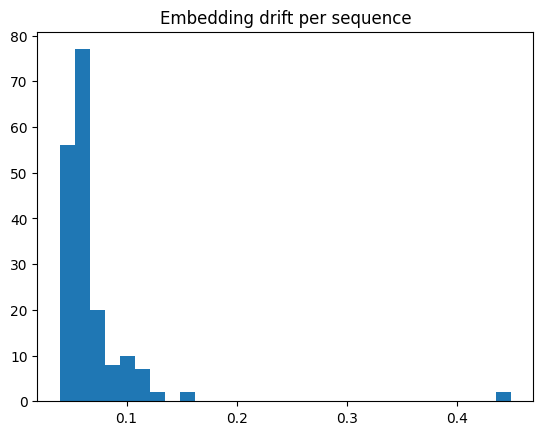

In [35]:
### Cosine similarity per sequence (best test)
cos = torch.nn.functional.cosine_similarity(start_embeddings, end_embeddings, dim=1)
print("mean cosine:", cos.mean().item())
print("min cosine:", cos.min().item())
print("max cosine:", cos.max().item())

### Norm difference per sequence
diff = (end_embeddings - start_embeddings).norm(dim=1)
print("mean L2 diff:", diff.mean().item())
print("max L2 diff:", diff.max().item())

### Embedding drift per point & plot histogram
drift = (end_embeddings - start_embeddings).norm(dim=1)
plt.hist(drift.numpy(), bins=30)
plt.title("Embedding drift per sequence")
plt.show()

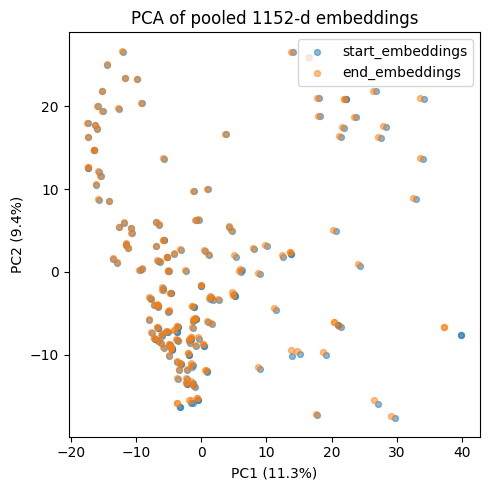

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_all = np.vstack([start_embeddings, end_embeddings])
X_all_std = StandardScaler().fit_transform(X_all)

pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

N1 = start_embeddings.shape[0]
N2 = end_embeddings.shape[0]

Z_start_embeddings = Z_all[:N1]
Z_end_embeddings = Z_all[N1:N1+N2]

plt.figure(figsize=(5,5))
plt.scatter(Z_start_embeddings[:,0], Z_start_embeddings[:,1], s=18, alpha=0.5, label="start_embeddings", marker='o')
plt.scatter(Z_end_embeddings[:,0], Z_end_embeddings[:,1], s=18, alpha=0.5, label="end_embeddings",   marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
seq = rsample_forESM_IF_df_filtered_longDf.sample(1, random_state=0).seq.item()

In [97]:
### Boosted ESM-Encoder
encoder = training_wrapper.model.seq_encoder.to("cuda")
print(len(seq))
atts = encoder.get_attentions([seq])
atts[32].shape

206


torch.Size([1, 20, 208, 208])

In [ ]:
encoderOld = ESM2EncoderOriginal().to("cuda")
print(len(seq))
atts = encoder.get_attentions([seq])
atts[32].shape

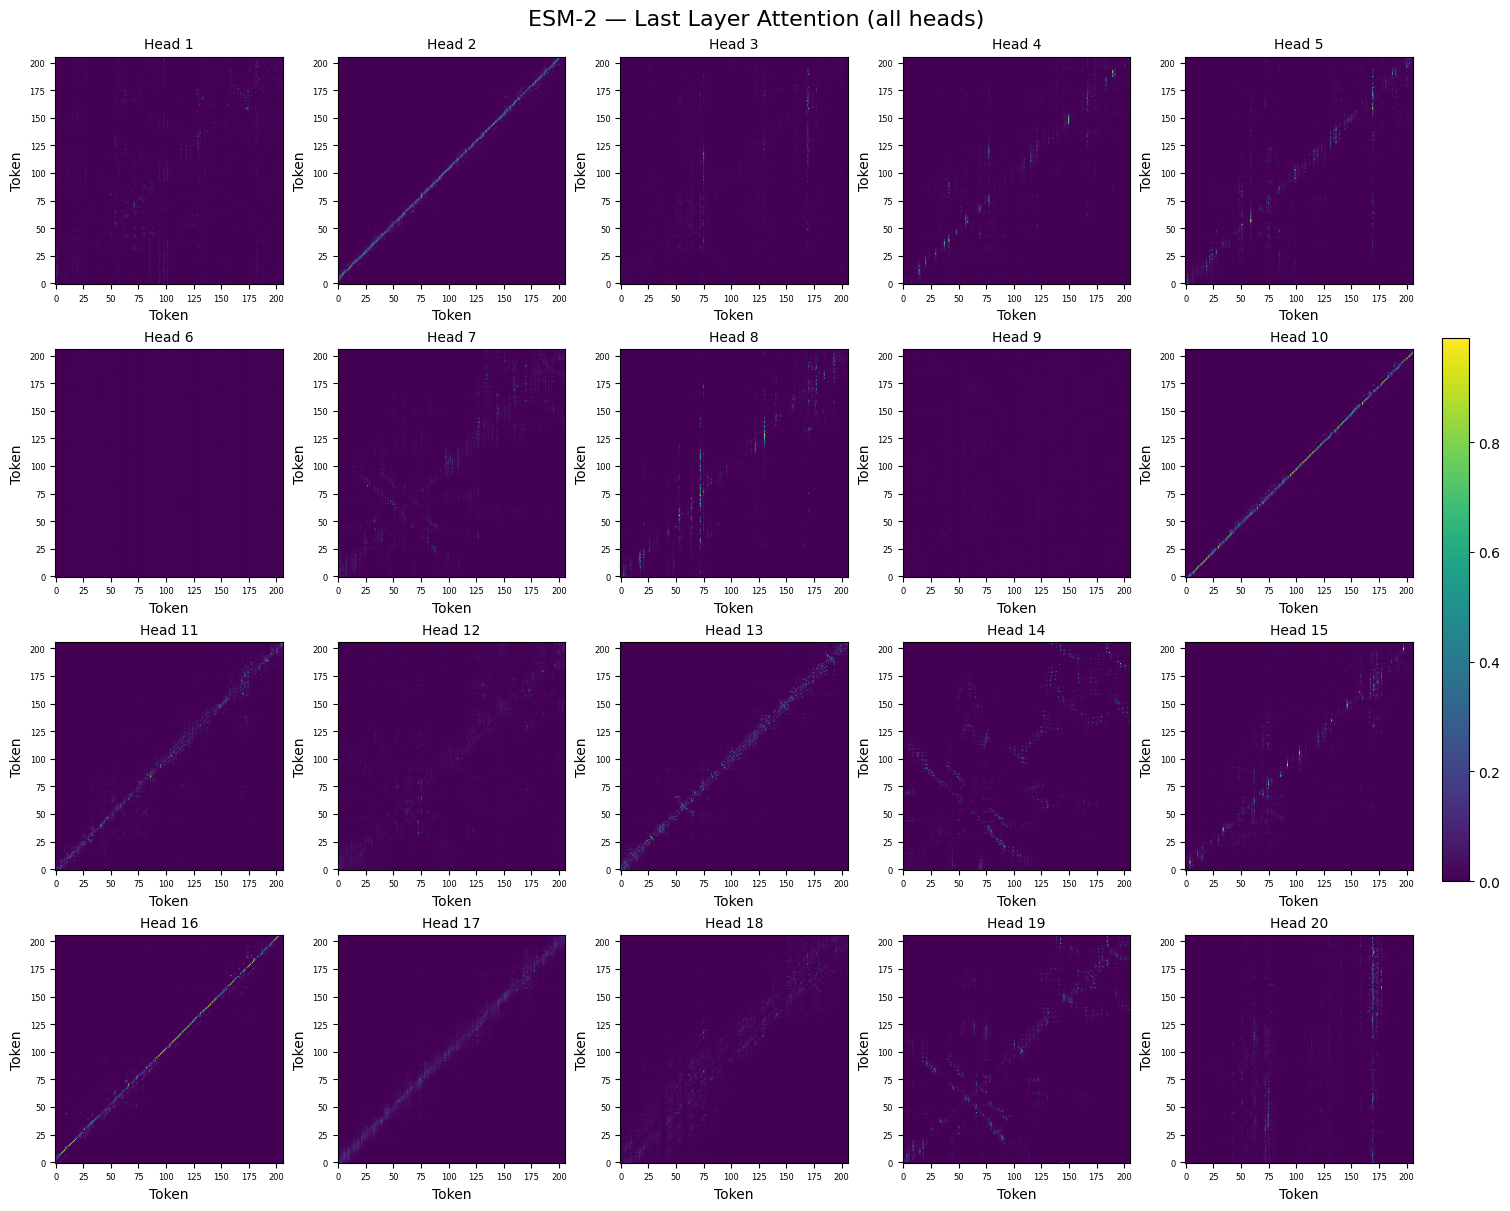

In [105]:
layer_idx = -1  # last layer
A = atts[layer_idx][0]     # shape [num_heads, T, T]
H = A.shape[0]

# Drop BOS/EOS if present
A = A[:, 1:-1, 1:-1]

cols = 5
rows = math.ceil(H / cols)

fig, axes = plt.subplots(rows, cols,
                         figsize=(3.0*cols, 3.0*rows),
                         constrained_layout=True)
axes = axes.ravel()

vmin = float(A.min())
vmax = float(A.max())

im0 = None

for h in range(rows * cols):
    ax = axes[h]
    if h < H:
        M = A[h].detach().cpu().numpy()
        im0 = ax.imshow(
            M,
            origin="lower",
            cmap="viridis", # magma, binary, inferno
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(f"Head {h+1}", fontsize=10)
        ax.set_xlabel("Token")
        ax.set_ylabel("Token")
        ax.tick_params(labelsize=6)
    else:
        ax.axis("off")

if im0 is not None:
    fig.colorbar(im0, ax=axes.tolist(), fraction=0.02, pad=0.02)

plt.suptitle("ESM-2 — Last Layer Attention (all heads)", fontsize=16)
plt.show()

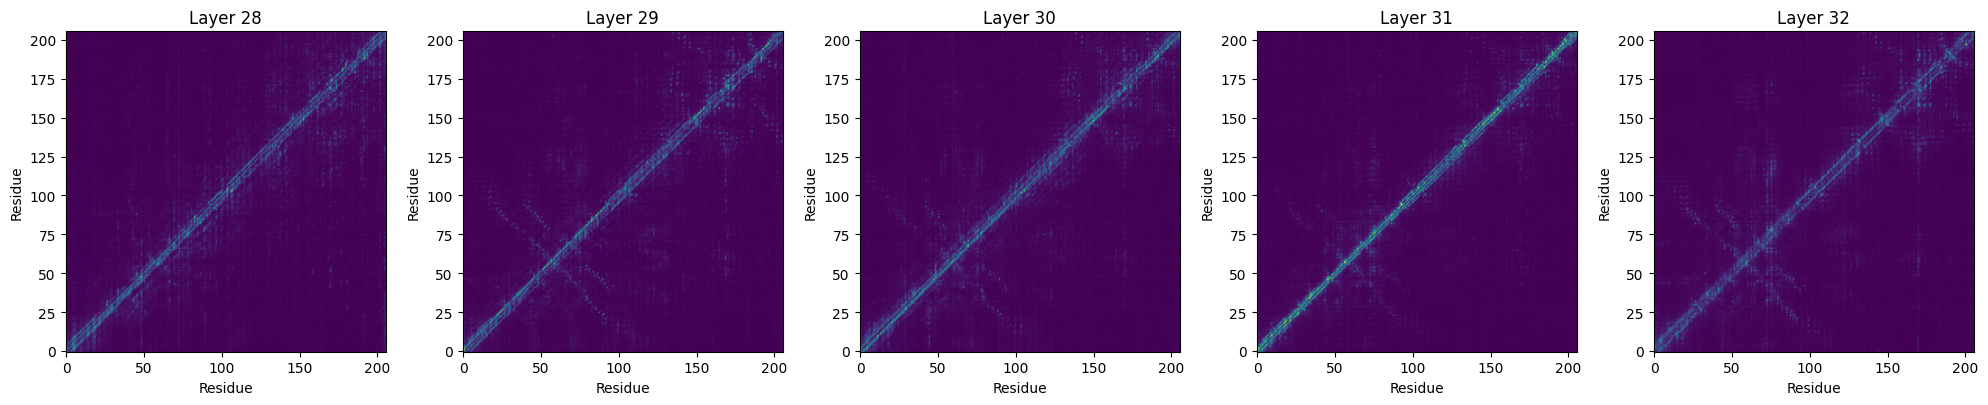

In [106]:
### Old ESM-Encoder
layer_ids = [28, 29, 30, 31, 32]
layer_maps = {}   # store summed maps

for L in layer_ids:
    A = atts[L][0]                  # [num_heads, T, T]
    A = A[:, 1:-1, 1:-1]            # drop BOS/EOS → [H, T', T']
    A_sum = A.sum(dim=0)            # sum heads → [T', T']
    layer_maps[L] = A_sum.cpu()

vmin = min(layer_maps[L].min() for L in layer_maps)
vmax = max(layer_maps[L].max() for L in layer_maps)

fig, axes = plt.subplots(1, len(layer_ids), figsize=(4*len(layer_ids), 4))

for ax, L in zip(axes, layer_ids):
    ax.imshow(layer_maps[L], cmap="viridis", origin="lower",
              vmin=vmin, vmax=vmax)
    ax.set_title(f"Layer {L}")
    ax.set_xlabel("Residue")
    ax.set_ylabel("Residue")

plt.tight_layout()
plt.show()

### Boosted ESM-Encoder
layer_ids = [28, 29, 30, 31, 32]
layer_maps = {}   # store summed maps

for L in layer_ids:
    A = atts[L][0]                  # [num_heads, T, T]
    A = A[:, 1:-1, 1:-1]            # drop BOS/EOS → [H, T', T']
    A_sum = A.sum(dim=0)            # sum heads → [T', T']
    layer_maps[L] = A_sum.cpu()

vmin = min(layer_maps[L].min() for L in layer_maps)
vmax = max(layer_maps[L].max() for L in layer_maps)

fig, axes = plt.subplots(1, len(layer_ids), figsize=(4*len(layer_ids), 4))

for ax, L in zip(axes, layer_ids):
    ax.imshow(layer_maps[L], cmap="viridis", origin="lower",
              vmin=vmin, vmax=vmax)
    ax.set_title(f"Layer {L}")
    ax.set_xlabel("Residue")
    ax.set_ylabel("Residue")

plt.tight_layout()
plt.show()

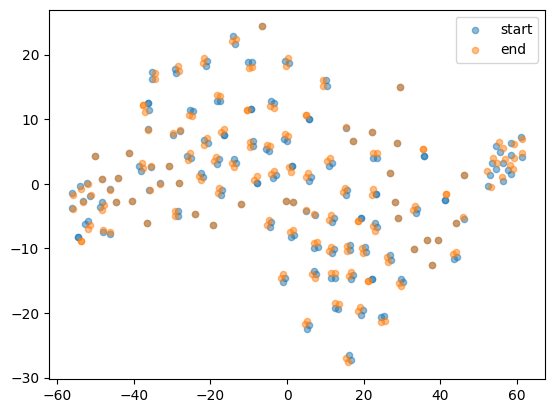

In [142]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

all_emb = torch.cat([start_embeddings, end_embeddings], dim=0).numpy()
labels = ["start"] * len(start_embeddings) + ["end"] * len(end_embeddings)

tsne = TSNE(n_components=2, perplexity=20)
emb2d = tsne.fit_transform(all_emb)

plt.scatter(emb2d[:184,0], emb2d[:184,1], alpha=0.5, label="start", s=20)
plt.scatter(emb2d[184:,0], emb2d[184:,1], alpha=0.5, label="end", s=20)
plt.legend()
plt.show()

### Trianing loop

In [ ]:
def batch(iterable, n=1):
    """Takes any indexable iterable (e.g., a list of observation IDs) and yields contiguous slices of length n."""
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

class TrainWrapper():

    def __init__(self, 
                 model, 
                 train_loader,
                 test_loader,
                 val_loader,
                 test_df,
                 test_dataset,
                 optimizer, 
                 epochs, 
                 runID, 
                 device, 
                 test_indexes_for_auROC = None,
                 auROC_batch_size=10, 
                 model_save_steps=False, 
                 model_save_path=False, 
                 v=False, 
                 wandb_tracker=False):
        
        self.model = model 
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.test_dataset = test_dataset
        self.test_df = test_df
        self.auROC_batch_size = auROC_batch_size
        
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device
        
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.best_vloss = 1_000_000
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.test_indexes_for_auROC = test_indexes_for_auROC

    def train_one_epoch(self):

        self.model.train() 
        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
            
            if batch[0].size(0) == 1: 
                continue
            
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

            del loss, batch
            torch.cuda.empty_cache()
            
        return running_loss / len(self.training_loader)

    def calc_auroc_aupr_on_indexes(self, model, dataset, dataframe, nondimer_indexes, batch_size = 10):

        self.model.eval()
        all_TP_scores, all_FP_scores = [], []
        accessions = [dataframe.loc[index].target_binder_id for index in nondimer_indexes]  # <-- use dataframe
        batches_local = batch(accessions, n=batch_size)
        
        with torch.no_grad():
            for index_batch in tqdm(batches_local, total=int(len(accessions)/batch_size), desc="Calculating AUC"):

                embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = dataset._get_by_name(index_batch)
                embedding_pep, embedding_prot = embedding_pep.to(self.device), embedding_prot.to(self.device)

                # Make sure this matches your model's signature:
                logit_matrix = self.model.calculate_logit_matrix(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
                
                TP_scores = logit_matrix.diag().detach().cpu().tolist()
                all_TP_scores += TP_scores
                
                # Get FP scores from upper triangle (excluding diagonal)
                n = logit_matrix.size(0)
                rows, cols = torch.triu_indices(n, n, offset=1)
                FP_scores = logit_matrix[rows, cols].detach().cpu().tolist()
                all_FP_scores += FP_scores
            
        all_score_predictions = np.array(all_TP_scores + all_FP_scores)
        all_labels = np.array([1]*len(all_TP_scores) + [0]*len(all_FP_scores))
                
        fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_score_predictions)
        auroc = metrics.roc_auc_score(all_labels, all_score_predictions)
        aupr  = metrics.average_precision_score(all_labels, all_score_predictions)
        
        return auroc, aupr, all_TP_scores, all_FP_scores

    def validate(self):
        
        self.model.eval()
        
        running_loss_Meta = 0.0
        all_logits = []
        all_lbls = []
        used_batches_meta = 0

        # --- MetaDataset validation ---
        with torch.no_grad():
            for batch in tqdm(self.validation_loader, total=len(self.validation_loader)):
                if batch[0].size(0) == 1:
                    continue
                __, __, __, __, labels = batch
                logits, loss = self.model.validation_step_MetaDataset(batch, self.device)
                
                running_loss_Meta += loss.item()
                all_logits.append(logits.detach().view(-1).cpu())
                all_lbls.append(labels.detach().view(-1).cpu())
                used_batches_meta += 1
                
            if used_batches_meta > 0:
                val_loss_Meta = running_loss_Meta / used_batches_meta
                all_logits = torch.cat(all_logits).numpy()
                all_lbls   = torch.cat(all_lbls).numpy()
            
                fpr, tpr, thresholds = metrics.roc_curve(all_lbls, all_logits)
                meta_auroc = metrics.roc_auc_score(all_lbls, all_logits)
                meta_aupr  = metrics.average_precision_score(all_lbls, all_logits)

                y_pred = (all_logits >= 0).astype(int)
                y_true = all_lbls.astype(int)
                val_acc_Meta = (y_pred == y_true).mean()
            else:
                val_loss_Meta = float("nan")
                meta_auroc = float("nan")
                meta_aupr = float("nan")
                val_acc_Meta = float("nan")

        # --- PPint validation ---
        running_loss_ValPPint = 0.0
        running_accuracy_ValPPint = 0.0
        used_batches_ppint = 0

        with torch.no_grad():
            for batch in tqdm(self.testing_loader, total=len(self.testing_loader)):
                if batch[0].size(0) == 1:
                    continue
                loss, peptide_accuracy = self.model.validation_step_PPint(batch, self.device)
                running_loss_ValPPint += loss.item()
                running_accuracy_ValPPint += peptide_accuracy.item()
                used_batches_ppint += 1
                
            if used_batches_ppint > 0:
                val_loss_PPint = running_loss_ValPPint / used_batches_ppint
                val_accuracy_PPint = running_accuracy_ValPPint / used_batches_ppint
            else:
                val_loss_PPint = float("nan")
                val_accuracy_PPint = float("nan")

        # --- AUROC on specific indexes (optional) ---
        if self.test_indexes_for_auROC is not None:
            non_dimer_auc, non_dimer_aupr, ___, ___ = self.calc_auroc_aupr_on_indexes(
                model=self.model, 
                dataset=self.test_dataset,
                dataframe=self.test_df,
                nondimer_indexes=self.test_indexes_for_auROC,
                batch_size=self.auROC_batch_size
            )
            
            return (val_loss_PPint, val_accuracy_PPint,
                    non_dimer_auc, non_dimer_aupr,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

        else:
            return (val_loss_PPint, val_accuracy_PPint,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

    def train_model(self):
        
        torch.cuda.empty_cache()
        
        if self.verbose:
            print(f"Training model {str(self.runID)}")

        # --- initial validation before training
        print("Initial validation before starting training")
        if self.test_indexes_for_auROC is not None:
            (val_loss_PPint, val_accuracy_PPint,
             non_dimer_auc, non_dimer_aupr,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
        else:
            (val_loss_PPint, val_accuracy_PPint,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            non_dimer_auc, non_dimer_aupr = None, None
                
        if self.verbose: 
            print(f'Before training:')
            print(f'Meta Val-Loss {round(val_loss_Meta,4)}')
            print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
            print(f'Meta AUROC: {round(meta_auroc,4)}')
            print(f'Meta AUPR: {round(meta_aupr,4)}')
            print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
            print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
            if non_dimer_auc is not None:
                print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
        
        if self.wandb_tracker:
            metrics_to_log = {
                "PPint Test-Loss": val_loss_PPint,
                "Meta Val-loss": val_loss_Meta,
                "PPint Accuracy": val_accuracy_PPint,
                "Meta Accuracy": val_acc_Meta,
                "Meta Val-AUROC": meta_auroc,
                "Meta Val-AUPR": meta_aupr,
            }
            if non_dimer_auc is not None:
                metrics_to_log.update({
                    "PPint non-dimer AUROC": non_dimer_auc,
                    "PPint non-dimer AUPR": non_dimer_aupr,
                })
            self.wandb_tracker.log(metrics_to_log)
        
        # --- training loop
        for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            
            # validation after epoch
            if self.test_indexes_for_auROC is not None:
                (val_loss_PPint, val_accuracy_PPint,
                 non_dimer_auc, non_dimer_aupr,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            else:
                (val_loss_PPint, val_accuracy_PPint,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
                non_dimer_auc, non_dimer_aupr = None, None
            
            torch.cuda.empty_cache()
            
            # checkpoint save
            if self.model_save_steps and epoch % self.model_save_steps == 0:
                check_point_folder = os.path.join(self.trained_model_dir, f"{str(self.runID)}_checkpoint_{str(epoch)}")
                if self.verbose:
                    print("Saving model to:", check_point_folder)
                os.makedirs(check_point_folder, exist_ok=True)
                checkpoint_path = os.path.join(check_point_folder, f"{str(self.runID)}_checkpoint_epoch_{str(epoch)}.pth")
                torch.save({'epoch': epoch, 
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(), 
                            'val_loss_PPint': val_loss_PPint,
                            'val_loss_Meta': val_loss_Meta},
                           checkpoint_path)
            
            # console logging
            if self.verbose and epoch % self.print_frequency_loss == 0:
                print(f'EPOCH {epoch}:')
                print(f'Meta Val Loss {round(val_loss_Meta,4)}')
                print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
                print(f'Meta AUROC: {round(meta_auroc,4)}')
                print(f'Meta AUPR: {round(meta_aupr,4)}')
                print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
                print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
                if non_dimer_auc is not None:
                    print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                    print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
            
            # wandb logging
            if self.wandb_tracker:
                metrics_to_log_epoch = {
                    "PPint Train-loss": train_loss,
                    "PPint Test-Loss": val_loss_PPint,
                    "Meta Val-loss": val_loss_Meta,
                    "PPint Accuracy": val_accuracy_PPint,
                    "Meta Accuracy": val_acc_Meta,
                    "Meta Val-AUROC": meta_auroc,
                    "Meta Val-AUPR": meta_aupr,
                }
                if non_dimer_auc is not None:
                    metrics_to_log_epoch.update({
                        "PPint non-dimer AUROC": non_dimer_auc,
                        "PPint non-dimer AUPR": non_dimer_aupr,
                    })
                self.wandb_tracker.log(metrics_to_log_epoch)

        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [ ]:
runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 5
batch_size = 3
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = torch.Generator().manual_seed(SEED)

optimizer = AdamW(model.parameters(), lr=learning_rate)
accelerator = Accelerator()
device = accelerator.device

trained_model_dir = f"/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_{runID}"
model_save_steps = 1

In [ ]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    # lbls = torch.tensor([float(x[4]) for x in batch])
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

train_dataloader = DataLoader(training_Dataset, batch_size=5, collate_fn=collate_varlen)
test_dataloader = DataLoader(testing_Dataset, batch_size=5, collate_fn=collate_varlen)
val_dataloader = DataLoader(validation_Dataset, batch_size=20, shuffle=False, drop_last = False, collate_fn=collate_varlen)

# accelerator
model, optimizer, train_dataloader, test_dataloader, val_dataloader = accelerator.prepare(model, optimizer, train_dataloader, test_dataloader, val_dataloader)

In [ ]:
# wandb
if use_wandb:
    run = wandb.init(
        project="CLIP_retrain_w_10percent_of_PPint",
        name=f"PPint0.1_PPint_test_meta_val_w_struct_CNNDilated_{runID}",
        config={"learning_rate": learning_rate, 
                "batch_size": batch_size, 
                "epochs": EPOCHS,
                "architecture": "MiniCLIP_w_transformer_crossattn", 
                "dataset": 
                "PPint"},
    )
    wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
else:
    run = None

# train
training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            val_loader=val_dataloader,
            test_df=Df_test,
            test_dataset=testing_Dataset,
            optimizer=optimizer,
            epochs=EPOCHS,
            runID=runID,
            device=device,
            test_indexes_for_auROC=indices_non_dimers_val,
            auROC_batch_size=10,
            model_save_steps=model_save_steps,
            model_save_path=trained_model_dir,
            v=True,
            wandb_tracker=wandb
)

training_wrapper.train_model() # start training